# 2019/12/02 - 2019/12/09
## Naive Bayes Implement by Luo

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.metrics import accuracy_score

### Iris Dataset
#### 75% for training 25% for testing

In [2]:
iris_data = datasets.load_iris()
print(iris_data.keys())

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])


In [3]:
iris_df = pd.DataFrame(iris_data['data'], columns=iris_data['feature_names'])
iris_df['target'] = iris_data['target']
iris_df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [4]:
random_indexs = np.random.permutation(len(iris_df))
train_sample_size = int(len(iris_df) * 0.75)
train_df = iris_df.iloc[random_indexs[:train_sample_size], [2, 3, 4]]
test_df = iris_df.iloc[random_indexs[train_sample_size:], [2, 3, 4]]
train_df.head()

,petal length (cm),petal width (cm),target
96,4.2,1.3,1
0,1.4,0.2,0
64,3.6,1.3,1
54,4.6,1.5,1
50,4.7,1.4,1


### Naive Bayse Based on
### $P(Class_i \mid x) = \frac {P(x \mid Class_i) \times P(Class_1)}{P(x \mid Class_1) \times P(Class_1) + ... + P(x \mid Class_n) \times P(Class_n)}$
#### Where  $P(x\mid Class_i) \sim multinomial(\mu, \Sigma)$

## Step1
### Caculate  $P(Class_i)$

In [5]:
### p(c1) P(c2) P(c3)
class_1_prob = len(train_df[train_df.target == 0]) / len(train_df)
class_2_prob = len(train_df[train_df.target == 1]) / len(train_df)
class_3_prob = len(train_df[train_df.target == 2]) / len(train_df)
print('p(Class_1): %f\np(Class_1): %f\np(Class_1): %f' % (class_1_prob, class_2_prob, class_3_prob))

p(Class_1): 0.392857
p(Class_1): 0.303571
p(Class_1): 0.303571


## Step 2
### Caculate $P(x \mid Class_i)$
### We assume 
### 1. $P(x\mid Class_i) \sim multinomial(\mu, \Sigma)$
### 2. Variables are independent (Covariance matrix is diagonal)
### By MLE method, $(\bar {x}, \sigma)$ are proper estimator for $(\mu, \Sigma)$

#### Caculate $(\bar {x}, \sigma)$

In [6]:
def mean_cov_caculate(df, label):
    view_df = df[df.target == label][['petal length (cm)', 'petal width (cm)']]
    sample_size = len(view_df)
    means = np.array(view_df.mean())
    variances = np.array(view_df.var())

    ## make it be diagonal
    cov = np.zeros((2, 2))
    for var, i in zip(variances, range(2)):
        cov[i, i] = var
    
    return sample_size, means, cov


In [7]:
sample_size_1, class_1_means, class_1_cov = mean_cov_caculate(train_df, 0)
sample_size_2, class_2_means, class_2_cov = mean_cov_caculate(train_df, 1)
sample_size_3, class_3_means, class_3_cov = mean_cov_caculate(train_df, 2)

In [8]:
cov = (class_1_cov + class_2_cov + class_3_cov) / 3

In [9]:
cov = (class_1_cov * sample_size_1 + class_2_cov * sample_size_2 + class_3_cov * sample_size_3) / len(train_df)

### Caculate Posterior probability

In [10]:
def caculate_posteriot_probability(features, means_alls, cov, prior_prob_alls):
    cond_probs = []
    for i, prior_prob in enumerate(prior_prob_alls):
        cond_prob = multivariate_normal.pdf(features, mean=means_alls[i], cov=cov)
        a = cond_prob * prior_prob
        cond_probs.append(a)
    prob_sum = sum(cond_probs)
    
    final_probs = np.round(cond_probs / prob_sum, 5)
    answer = np.argmax(final_probs)
    return final_probs, answer

### Check Train Accuracy

In [11]:
predict_trains = []
for i in range(len(train_df)):
    predict_ans = caculate_posteriot_probability(
                  train_df.iloc[i, [0, 1]],
                  means_alls=[class_1_means, class_2_means, class_3_means],
                  cov=cov,
                  prior_prob_alls=[class_1_prob, class_2_prob, class_3_prob])[1]
    predict_trains.append(predict_ans)

In [12]:
accuracy_score(train_df['target'], predict_trains)

0.9732142857142857

### Check Test Accuracy

In [13]:
predict_tests = []
for i in range(len(test_df)):
    predict_ans = caculate_posteriot_probability(
                  test_df.iloc[i, [0, 1]],
                  means_alls=[class_1_means, class_2_means, class_3_means],
                  cov=cov,
                  prior_prob_alls=[class_1_prob, class_2_prob, class_3_prob])[1]
    predict_tests.append(predict_ans)

In [14]:
accuracy_score(test_df['target'], predict_tests)

0.9210526315789473

### Plot Decision Boundary 
#### (Because  covariance matrixs are identity, decision boundary is linear)

In [15]:
def make_meshgrid(x, y, h=0.01):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(
        np.arange(x_min, x_max, h),
        np.arange(y_min, y_max, h))
    
    return xx, yy

#### Caculate Model Predictions on Every Points 

In [16]:
xx, yy = make_meshgrid(train_df.iloc[:, 0], train_df.iloc[:, 1])
coordinates = np.c_[xx.ravel(), yy.ravel()]

predictions = []
for a in coordinates:
    predict_ans = caculate_posteriot_probability(
                  a,
                  means_alls=[class_1_means, class_2_means, class_3_means],
                  cov=cov,
                  prior_prob_alls=[class_1_prob, class_2_prob, class_3_prob])[1]
    predictions.append(predict_ans)
    
predictions = np.array(predictions).reshape(xx.shape)

Text(0, 0.5, 'petal width')

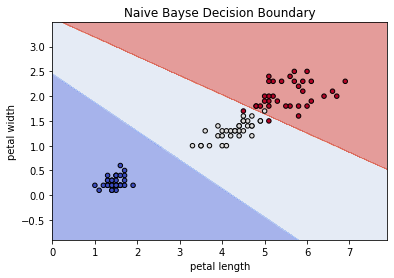

In [17]:
plt.contourf(xx, yy, predictions, cmap=plt.cm.coolwarm, alpha=0.5)
plt.scatter(train_df.iloc[:, 0], train_df.iloc[:, 1], c=train_df.iloc[:, 2], cmap=plt.cm.coolwarm, s=20, edgecolors='k')
plt.title('Naive Bayse Decision Boundary')
plt.xlabel('petal length')
plt.ylabel('petal width')